<a href="https://colab.research.google.com/github/abhiiyer/ERA1/blob/main/Session-11/Entire_Working_Code_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170498071/170498071 [00:13<00:00, 12261795.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/20, Train Loss: 1.7067, Train Accuracy: 37.13%, Test Loss: 1.7810, Test Accuracy: 45.55%
Epoch 2/20, Train Loss: 1.2453, Train Accuracy: 55.00%, Test Loss: 1.1414, Test Accuracy: 60.75%
Epoch 3/20, Train Loss: 1.0400, Train Accuracy: 62.93%, Test Loss: 1.0454, Test Accuracy: 63.74%
Epoch 4/20, Train Loss: 0.9075, Train Accuracy: 68.23%, Test Loss: 0.9529, Test Accuracy: 67.93%
Epoch 5/20, Train Loss: 0.8163, Train Accuracy: 71.16%, Test Loss: 1.0417, Test Accuracy: 67.21%
Epoch 6/20, Train Loss: 0.7576, Train Accuracy: 73.72%, Test Loss: 0.9385, Test Accuracy: 69.01%
Epoch 7/20, Train Loss: 0.7090, Train Accuracy: 75.52%, Test Loss: 0.6805, Test Accuracy: 76.71%
Epoch 8/20, Train Loss: 0.6791, Train Accuracy: 76.37%, Test Loss: 0.6075, Test Accuracy: 78.67%
Epoch 9/20, Train Loss: 0.6537, Train Accuracy: 77.35%, Test Loss: 0.6763, Test Accuracy: 77.35%
Epoch 10/20, Train Loss: 0.6360, Train

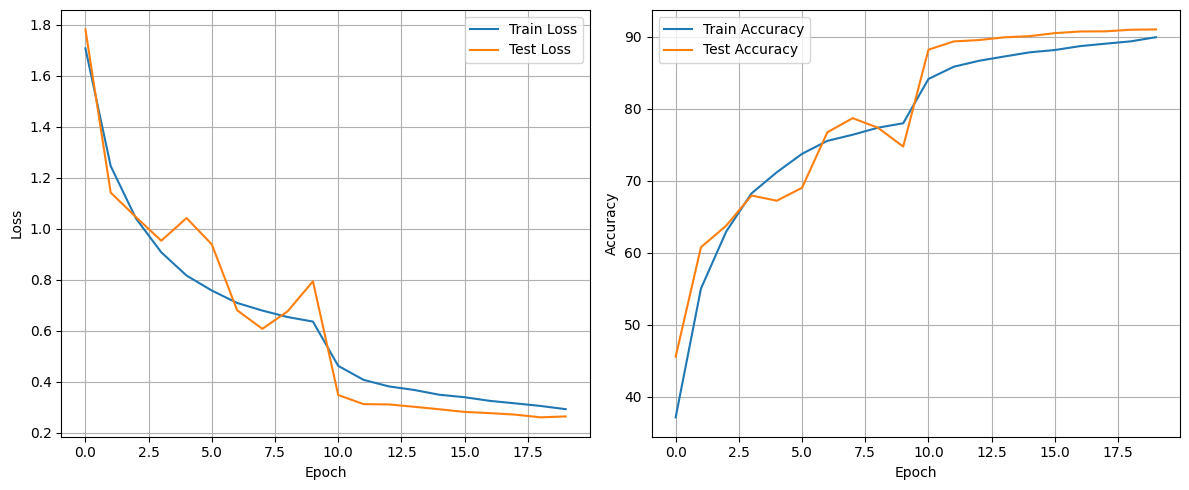

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
!pip install grad-cam
from pytorch_grad_cam import GradCAM

# Step 1: Define ResNet model (ResNet-18 or ResNet-34)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

# Step 2: Load and preprocess CIFAR-10 dataset

class CustomCutout:
    def __init__(self, size=16):
        self.size = size

    def __call__(self, img):
        img = TF.to_tensor(img)
        h, w = img.size(1), img.size(2)
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - self.size // 2, 0, h)
        y2 = np.clip(y + self.size // 2, 0, h)
        x1 = np.clip(x - self.size // 2, 0, w)
        x2 = np.clip(x + self.size // 2, 0, w)
        img[:, y1:y2, x1:x2] = 0.5  # You can set this to 0 for black or 0.5 for gray
        return TF.to_pil_image(img)

# Training set transformations (with data augmentations)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    CustomCutout(16),  # Adding Cutout here
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# Test set transformations (without data augmentations)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Step 3: Training the ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_resnet(model, criterion, optimizer, scheduler, num_epochs=10):
    model.to(device)

    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []

    max_test_accuracy = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            #Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_loss_list.append(train_loss)
        train_acc_list.append(train_accuracy)

        # Evaluate on the test set
        test_loss, test_accuracy = evaluate_model(model, criterion, testloader)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_accuracy)

         # Learning Rate Scheduling
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        # Update max_test_accuracy and best_epoch
        if test_accuracy > max_test_accuracy:
            max_test_accuracy = test_accuracy
            best_epoch = epoch + 1

            # Save the best model
            save_path = f"best_model_epoch{best_epoch}_testacc{test_accuracy:.2f}.pth"
            torch.save(model.state_dict(), save_path)

    print(f"\nMax Test Accuracy: {max_test_accuracy:.2f}% achieved at Epoch {best_epoch}")

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

def evaluate_model(model, criterion, dataloader):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_loss /= len(dataloader)
    test_accuracy = 100. * correct_test / total_test
    return test_loss, test_accuracy

# Use ResNet18() or ResNet34() to select the model
model = ResNet18()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce learning rate by a factor of 0.1 every 10 epochs


num_epochs = 20
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train_resnet(model, criterion, optimizer, scheduler, num_epochs)

# Plot training and test accuracy/loss
def plot_accuracy_loss(train_loss_list, test_loss_list, train_acc_list, test_acc_list):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(test_loss_list, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Train Accuracy')
    plt.plot(test_acc_list, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_accuracy_loss(train_loss_list, test_loss_list, train_acc_list, test_acc_list)

Correctly Classified: True Class: cat, Predicted Class: cat
Correctly Classified: True Class: ship, Predicted Class: ship


Correctly Classified: True Class: ship, Predicted Class: ship
Correctly Classified: True Class: plane, Predicted Class: plane
Correctly Classified: True Class: frog, Predicted Class: frog
Correctly Classified: True Class: frog, Predicted Class: frog


Correctly Classified: True Class: car, Predicted Class: car
Correctly Classified: True Class: frog, Predicted Class: frog
Correctly Classified: True Class: cat, Predicted Class: cat
Correctly Classified: True Class: car, Predicted Class: car


Misclassified: True Class: car, Predicted Class: truck
Misclassified: True Class: plane, Predicted Class: truck


Misclassified: True Class: deer, Predicted Class: dog
Misclassified: True Class: frog, Predicted Class: cat
Misclassified: True Class: cat, Predicted Class: dog


Misclassified: True Class: cat, Predicted Class: dog
Misclassified: True Class: cat, Predicted Class: dog


Misclassified: True Class: bird, Predicted Class: dog


Misclassified: True Class: frog, Predicted Class: bird
Misclassified: True Class: bird, Predicted Class: frog


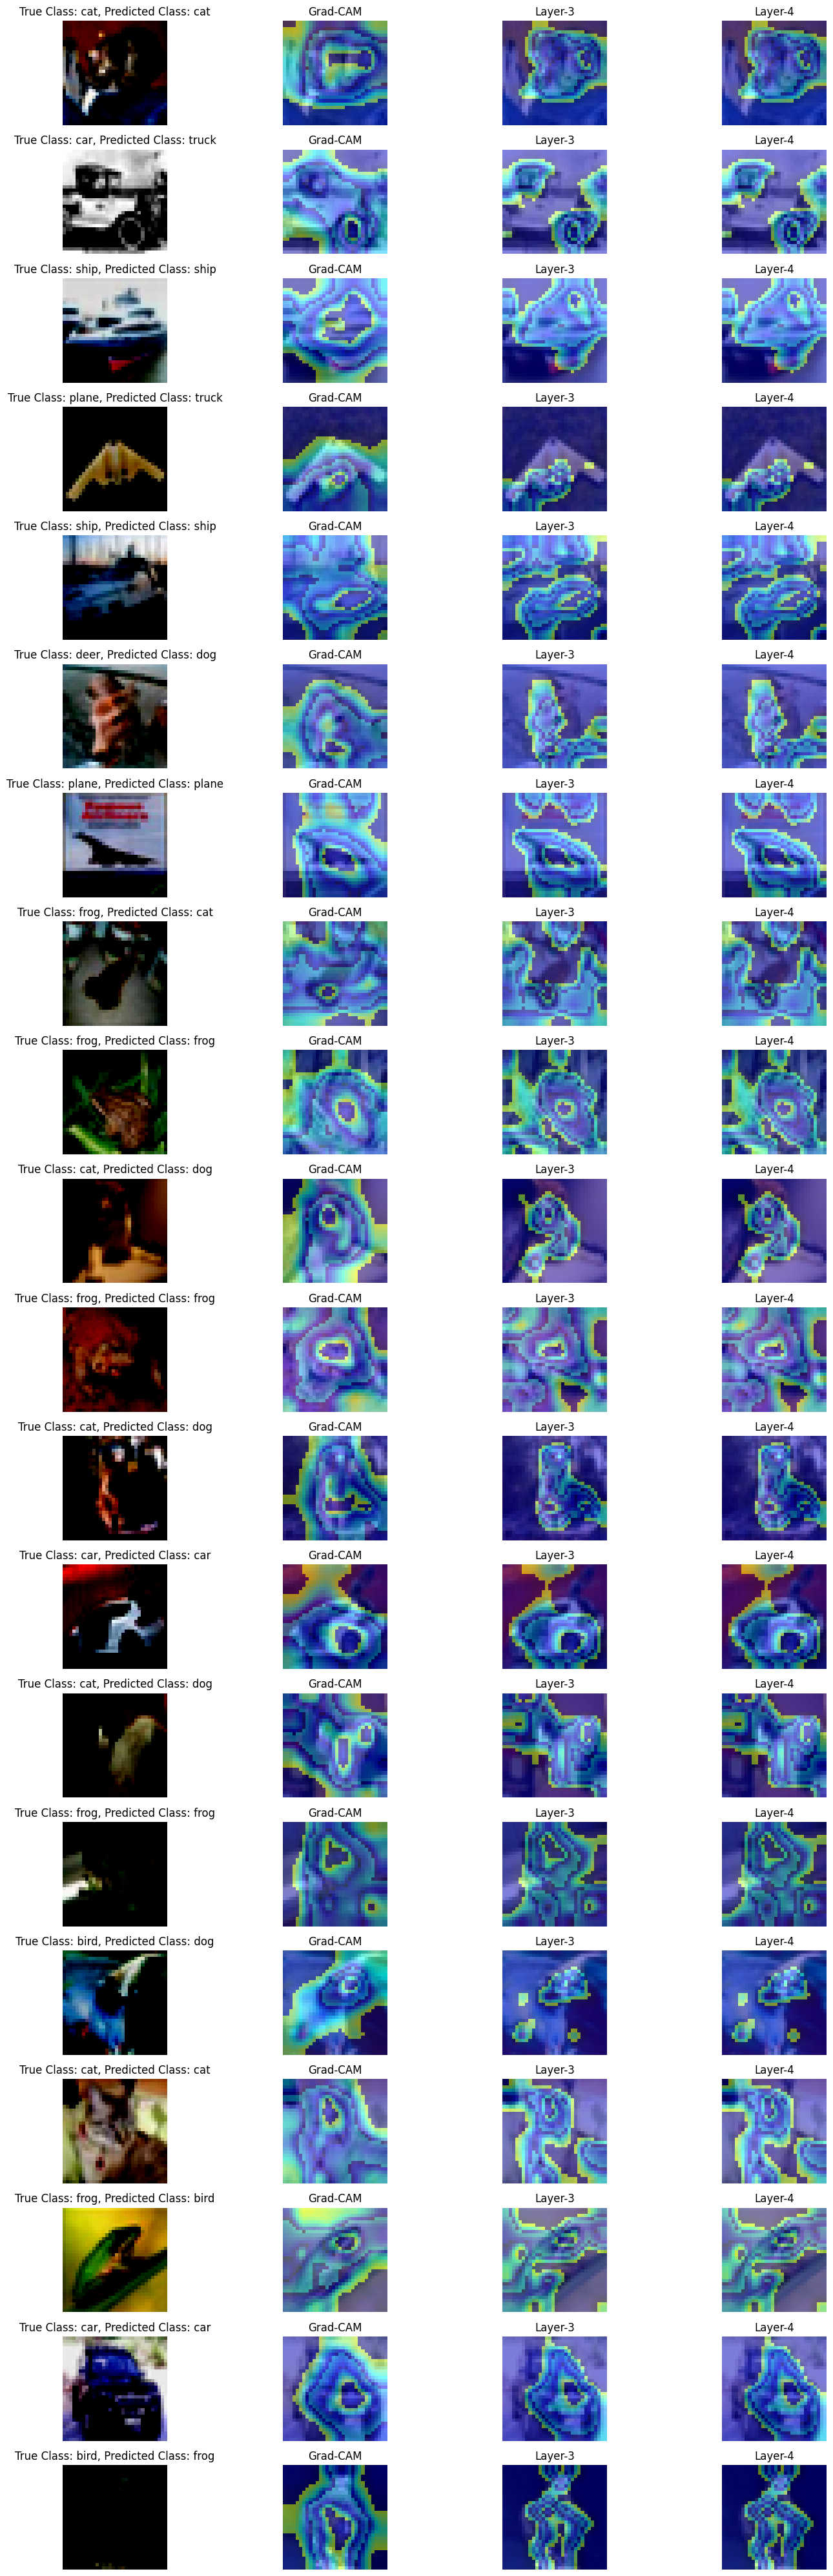

In [3]:
from pytorch_grad_cam.utils.image import show_cam_on_image

# Step 6: Show 10 correctly classified and 10 misclassified images with Grad-CAM
def show_correct_and_misclassified_images(model, class_names):
    model.eval()

    correct_images_count = 0
    misclassified_images_count = 0

    fig, axes = plt.subplots(20, 4, figsize=(15, 40))

    for i, (image, label) in enumerate(testset):
        image = image.to(device)  # Move image tensor to the device

        output = model(image.unsqueeze(0))

        _, predicted = output.max(1)

        if predicted.item() == label and correct_images_count < 10:
            # Correctly classified image
            print(f"Correctly Classified: True Class: {class_names[label]}, Predicted Class: {class_names[predicted.item()]}")

            # Use target_layers=[model.layer3[-1], model.layer4[-1]] (for the last layer) for visualization of correctly classified images
            target_layers = [model.layer3[-1], model.layer4[-1]]
            cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

            # Normalize the input image to be in the range [0, 1] with np.float32 data type
            image_normalized = image.cpu().squeeze().numpy().transpose(1, 2, 0)
            image_normalized = (image_normalized - image_normalized.min()) / (image_normalized.max() - image_normalized.min())
            image_normalized = np.float32(image_normalized)

            # Grad-CAM visualization
            grayscale_cam = cam(input_tensor=image.unsqueeze(0))
            heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam[0]), cv2.COLORMAP_JET)
            gradcam_image = show_cam_on_image(image_normalized, heatmap, use_rgb=True)

            # Layer-3 visualization
            cam.target_layers = [model.layer3[-1]]
            grayscale_cam = cam(input_tensor=image.unsqueeze(0))
            heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam[0]), cv2.COLORMAP_JET)
            layer3_image = show_cam_on_image(image_normalized, heatmap, use_rgb=True)

            # Layer-4 visualization
            cam.target_layers = [model.layer4[-1]]
            grayscale_cam = cam(input_tensor=image.unsqueeze(0))
            heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam[0]), cv2.COLORMAP_JET)
            layer4_image = show_cam_on_image(image_normalized, heatmap, use_rgb=True)

            # Display images
            axes[correct_images_count * 2, 0].imshow(np.transpose(image.cpu(), (1, 2, 0)))
            axes[correct_images_count * 2, 0].set_title(f"True Class: {class_names[label]}, Predicted Class: {class_names[predicted.item()]}")
            axes[correct_images_count * 2, 0].axis('off')

            axes[correct_images_count * 2, 1].imshow(gradcam_image)
            axes[correct_images_count * 2, 1].set_title("Grad-CAM")
            axes[correct_images_count * 2, 1].axis('off')

            axes[correct_images_count * 2, 2].imshow(layer3_image)
            axes[correct_images_count * 2, 2].set_title("Layer-3")
            axes[correct_images_count * 2, 2].axis('off')

            axes[correct_images_count * 2, 3].imshow(layer4_image)
            axes[correct_images_count * 2, 3].set_title("Layer-4")
            axes[correct_images_count * 2, 3].axis('off')

            correct_images_count += 1

        elif predicted.item() != label and misclassified_images_count < 10:
            # Misclassified image
            print(f"Misclassified: True Class: {class_names[label]}, Predicted Class: {class_names[predicted.item()]}")

            # Use target_layers=[model.layer3[-1], model.layer4[-1]] (for the last layer) for visualization of misclassified images
            target_layers = [model.layer3[-1], model.layer4[-1]]
            cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

            # Normalize the input image to be in the range [0, 1] with np.float32 data type
            image_normalized = image.cpu().squeeze().numpy().transpose(1, 2, 0)
            image_normalized = (image_normalized - image_normalized.min()) / (image_normalized.max() - image_normalized.min())
            image_normalized = np.float32(image_normalized)

            # Grad-CAM visualization
            grayscale_cam = cam(input_tensor=image.unsqueeze(0))
            heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam[0]), cv2.COLORMAP_JET)
            gradcam_image = show_cam_on_image(image_normalized, heatmap, use_rgb=True)

            # Layer-3 visualization
            cam.target_layers = [model.layer3[-1]]
            grayscale_cam = cam(input_tensor=image.unsqueeze(0))
            heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam[0]), cv2.COLORMAP_JET)
            layer3_image = show_cam_on_image(image_normalized, heatmap, use_rgb=True)

            # Layer-4 visualization
            cam.target_layers = [model.layer4[-1]]
            grayscale_cam = cam(input_tensor=image.unsqueeze(0))
            heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam[0]), cv2.COLORMAP_JET)
            layer4_image = show_cam_on_image(image_normalized, heatmap, use_rgb=True)

            # Display images
            axes[misclassified_images_count * 2 + 1, 0].imshow(np.transpose(image.cpu(), (1, 2, 0)))
            axes[misclassified_images_count * 2 + 1, 0].set_title(f"True Class: {class_names[label]}, Predicted Class: {class_names[predicted.item()]}")
            axes[misclassified_images_count * 2 + 1, 0].axis('off')

            axes[misclassified_images_count * 2 + 1, 1].imshow(gradcam_image)
            axes[misclassified_images_count * 2 + 1, 1].set_title("Grad-CAM")
            axes[misclassified_images_count * 2 + 1, 1].axis('off')

            axes[misclassified_images_count * 2 + 1, 2].imshow(layer3_image)
            axes[misclassified_images_count * 2 + 1, 2].set_title("Layer-3")
            axes[misclassified_images_count * 2 + 1, 2].axis('off')

            axes[misclassified_images_count * 2 + 1, 3].imshow(layer4_image)
            axes[misclassified_images_count * 2 + 1, 3].set_title("Layer-4")
            axes[misclassified_images_count * 2 + 1, 3].axis('off')

            misclassified_images_count += 1

        if correct_images_count >= 10 and misclassified_images_count >= 10:
            break

    plt.tight_layout()
    plt.show()

# Call show_correct_and_misclassified_images() to display the images and Grad-CAMs
show_correct_and_misclassified_images(model, classes)
